# Import libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import math
import statistics
import descartes 
import geopandas as gpd
from shapely.geometry import Point, Polygon
import re
import wordcloud

# Import restaurant data

In [2]:
restaurant = pd.read_csv("D:\Tony\Programming\Datasets\Yelp\yelp_restaurant.csv", encoding='utf-8')

# Restaurant EDA

### Data overview

In [3]:
restaurant.shape

(63961, 14)

In [4]:
restaurant.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,404 E Green St,Champaign,IL,61820,40.110446,-88.233073,4.5,5,1,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Ethnic Food, Food Trucks, Specialty Food, Impo...","{'Monday': '11:30-14:30', 'Tuesday': '11:30-14..."
1,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,4508 E Independence Blvd,Charlotte,NC,28205,35.194894,-80.767442,3.0,5,0,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...","Food, Restaurants, Grocery, Middle Eastern",NaN
2,eBEfgOPG7pvFhb2wcG9I7w,Philthy Phillys,"15480 Bayview Avenue, unit D0110",Aurora,ON,L4G 7J1,44.010962,-79.448677,4.5,4,1,"{'RestaurantsTableService': 'False', 'Restaura...","Restaurants, Cheesesteaks, Poutineries","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
3,lu7vtrp_bE9PnxWfA8g4Pg,Banzai Sushi,300 John Street,Thornhill,ON,L3T 5W4,43.820492,-79.398466,4.5,7,1,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","Japanese, Fast Food, Food Court, Restaurants",NaN
4,9sRGfSVEfLhN_km60YruTA,Apadana Restaurant,13071 Yonge Street,Richmond Hill,ON,L4E 1A5,43.947011,-79.454862,3.0,3,1,"{'Ambience': ""{'touristy': False, 'hipster': F...","Persian/Iranian, Turkish, Middle Eastern, Rest...","{'Tuesday': '12:0-21:0', 'Wednesday': '12:0-21..."


### Check missing data

In [5]:
for column in restaurant.columns:
    print(column, restaurant[column].isna().values.any(), sep=": ")

business_id: False
name: False
address: True
city: False
state: False
postal_code: True
latitude: False
longitude: False
stars: False
review_count: False
is_open: False
attributes: True
categories: False
hours: True


There are no missing entries in *business_id* and *name*, thus I will not remove any observation for now. 

### Number of restaurants by city

In [6]:
# Group by city and state
gb = restaurant.groupby(['city', 'state'])
counts = gb.size().to_frame(name='counts')
cities = (counts
          .join(gb.agg({'stars': 'mean'}).rename(columns={'stars': 'stars_mean'}))
          .join(gb.agg({'review_count': 'sum'}))
          .join(gb.agg({'latitude': 'mean'}).rename(columns={'latitude': 'lat_mean'}))
          .join(gb.agg({'longitude': 'mean'}).rename(columns={'longitude': 'lon_mean'}))
          .reset_index()
         ).sort_values(['counts'], ascending=False)
cities.head()

,city,state,counts,stars_mean,review_count,lat_mean,lon_mean
757,Toronto,ON,8680,3.439055,420487,43.682827,-79.391899
328,Las Vegas,NV,6936,3.505118,1455134,36.129357,-115.192354
555,Phoenix,AZ,4220,3.445379,492302,33.516868,-112.063541
443,Montréal,QC,4097,3.696119,133332,45.512710,-73.586994
89,Calgary,AB,3115,3.443981,68487,51.040528,-114.067612


Text(0.5, 1.0, 'Top 10 cities with most restaurants')

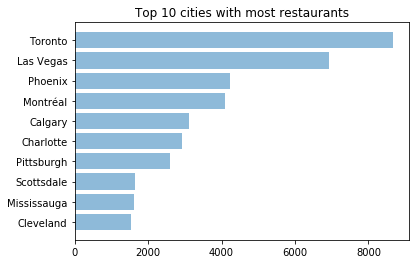

In [7]:
# Top 10 cities with most restaurants  
plt.barh(cities.sort_values(['counts'], ascending=True).tail(10)['city'], 
         cities.sort_values(['counts'], ascending=True).tail(10)['counts'], 
         align='center', alpha=0.5)
plt.title("Top 10 cities with most restaurants")

### Number of reviews by city

Text(0.5, 1.0, 'Top 10 cities with most reviews')

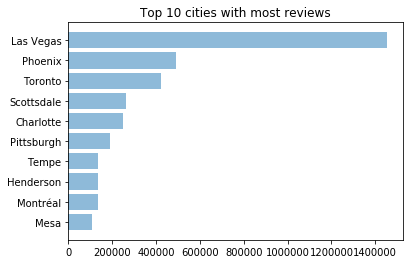

In [8]:
# Top 10 cities with most reviews
plt.barh(cities.sort_values(['review_count'], ascending=True).tail(10)['city'], 
         cities.sort_values(['review_count'], ascending=True).tail(10)['review_count'], 
         align='center', alpha=0.5)
plt.title("Top 10 cities with most reviews")

In this dataset there are lots of Canadian restaurants, including restaurants in Toronto, Montreal, and Calgary. As for restaurants in the US, their locations include Las Vegas, Phoenix, Charlotte, and Pittsburgh. However, from the number of reviews we may see that Americans seem to be more passionate about leaving reviews, as the number of reviews in Canadian cities are less than that in American cities in average. Comparing to **Figure X**, We may see that the dot sizes of Canadian cities shrink significantly in **Figure Y**.

### Average stars

Text(0.5, 1.0, 'Histogram of average stars by city')

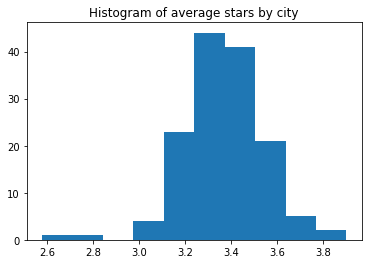

In [9]:
# Distribution of average stars (with count_reviews > 1000)
plt.hist(cities[cities['review_count'] > 1000]['stars_mean'])
plt.title('Histogram of average stars by city')

Most citiess have their average stars around 3.4 stars. 

Text(0.5, 1.0, 'Histogram of average stars by restaurant')

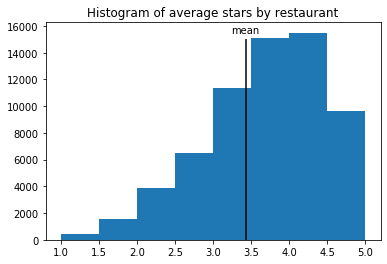

In [10]:
plt.hist(restaurant['stars'], bins=8)
plt.vlines(x=statistics.mean(restaurant['stars']), ymin=0, ymax=15000)
plt.text(x=statistics.mean(restaurant['stars'])-0.2, y=15500, s="mean")
plt.title('Histogram of average stars by restaurant')

Most restaurants have their average stars above 3 stars with grand mean around 3.5 stars.

### Plot cities on map

In [11]:
# Boundary for the map
# Ref: https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db
BBox = (restaurant['longitude'].min(), restaurant['longitude'].max(),
        restaurant['latitude'].min(),   restaurant['latitude'].max())
BBox

(-158.02552521229998, -72.80655, 21.497257820700003, 51.2941841)

In [12]:
# Remove the one observation in Hawaii to make a better map
restaurant = restaurant[restaurant['state'] != 'HI']

# Regroup by city and state
gb = restaurant.groupby(['city', 'state'])
counts = gb.size().to_frame(name='counts')
cities = (counts
          .join(gb.agg({'stars': 'mean'}).rename(columns={'stars': 'stars_mean'}))
          .join(gb.agg({'review_count': 'sum'}))
          .join(gb.agg({'latitude': 'mean'}).rename(columns={'latitude': 'lat_mean'}))
          .join(gb.agg({'longitude': 'mean'}).rename(columns={'longitude': 'lon_mean'}))
          .reset_index()
         ).sort_values(['counts'], ascending=False)

# Boundary of map
BBox = (restaurant['longitude'].min()-5, restaurant['longitude'].max()+5,
        restaurant['latitude'].min()-8,   restaurant['latitude'].max()+5)
BBox

(-128.0489077657, -67.80655, 24.742442630300005, 56.2941841)

In [13]:
# Import base map
yelp_map = plt.imread(r'D:\Tony\Programming\Datasets\Yelp\yelp_map.png')

In [14]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

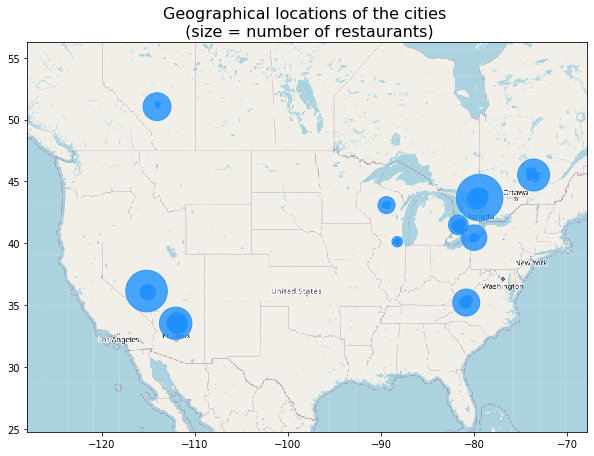

In [15]:
# Setup for scatter plot 
fig, ax = plt.subplots(figsize=(8.37*1.2,5.98*1.2))

# Create scatter points
scatter = ax.scatter(cities['lon_mean'], cities['lat_mean'], zorder=1, alpha=0.8, c='dodgerblue', s=cities['counts']/4)

# Set x y limits and title
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.set_title("Geographical locations of the cities \n (size = number of restaurants)", fontsize=16)

ax.imshow(yelp_map, zorder=0, extent=BBox, aspect='auto')
plt.show()

### Plot reviews and average stars on map

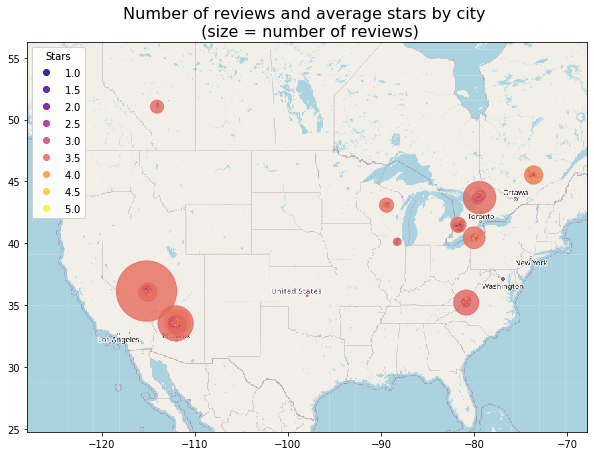

In [16]:
# Setup for scatter plot 
fig, ax = plt.subplots(figsize=(8.37*1.2,5.98*1.2))

# Create scatter points
scatter = ax.scatter(cities['lon_mean'], cities['lat_mean'], 
                     zorder=1, alpha=0.8, c=cities['stars_mean'], cmap='plasma', 
                     s=cities['review_count']/400)

# Set x y limits and title
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.set_title("Number of reviews and average stars by city \n (size = number of reviews)", fontsize=16)

# Add legend
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Stars")
ax.add_artist(legend1)

ax.imshow(yelp_map, zorder=0, extent=BBox, aspect='auto')
plt.show()

### Popularity metric

In [17]:
restaurant['popularity'] = (restaurant['stars']-3)*np.log(restaurant['review_count'])

Text(0.5, 1.0, 'Histogram of restaurant popularities')

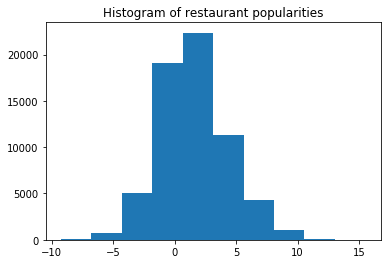

In [18]:
plt.hist(restaurant['popularity'])
plt.title('Histogram of restaurant popularities')

### Popular categories

In [20]:
# Create text given all categories
categories_cloud = ""
for i in range(len(restaurant)):
    text = restaurant['categories'].iloc[i].split(", ")
    text = ' '.join(text)
    text = text.replace("Food", "")
    text = text.replace("Restaurant", "")
    text = text.replace("Restaurants", "")
    text = ' '.join(text.split())
    # text = re.sub("[^\w\s']", "", text)
    categories_cloud += text
    categories_cloud += " "

In [21]:
# Build word cloud
categoriesWordCloud = wordcloud.WordCloud(width = 1600, height = 800, background_color ='white').generate(categories_cloud)

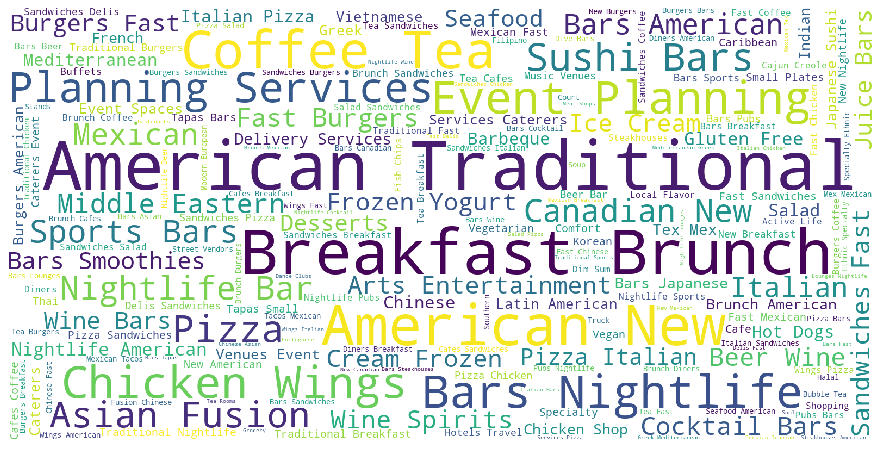

In [22]:
# plot the WordCloud image                        
plt.figure(figsize = (16, 8), facecolor=None) 
plt.imshow(categoriesWordCloud) 
plt.axis("off")
plt.show() 

From the word cloud we may see that American restaurant is the predominant type of restaurant in the dataset. Some other noticable types include Asian Fusion, Mexican, Middle Eastern, and Italian. In addition, a significant element in the categories is bars; we may see that there are multiple keywords relevant to bars: nightlife bars, sport bars, and cocktail bars. Another significant element is fast foods with keywords such as chicken wings, fast, pizza, and burgers. Some other important elements include breakfast/brunch and coffee/tea, which are offered by many American restaurants. 